In [1]:
# %% 1 IMPORTS & CONFIG
import pandas as pd
import matplotlib.pyplot as plt
import json

# Parameters copied from index.html
DWELL_MS      = 800          # dwell threshold (ms)
GROW_AFTER_MS = 120          # delay before a box starts growing (ms)

CSV_FILE      = "gaze_data (3).csv"   # input
EP_OUT        = "episodes.csv"       # output episodes
MET_OUT       = "metrics.json"       # output metrics


In [7]:
# %% 2  LOAD DATA & SAMPLING RATE
s = (pd.read_csv(CSV_FILE)
       .sort_values('timestamp')
       .assign(lasthit=lambda d: d['lasthit'].fillna('')))

# median inter-sample interval ≈ eye-tracker period
SAMPLING_MS = s['timestamp'].diff().median()
SAMPLING_MS


39.5

In [21]:
# %% 3  DETECT DWELL EPISODES  + FLICKER TIME
episodes = []
cur_id = ''
start_ts = prev_ts = None
grow_on = False
flicker_frames = 0
fired = False

for r in s.itertuples():
    same = (r.lasthit == cur_id) and r.lasthit != ''
    
    # -- episode boundary ----------------------------------------------------
    if not same:
        if cur_id:                       # close the previous episode
            duration = prev_ts - start_ts
            flicker_ms = flicker_frames * SAMPLING_MS
            saved = fired and grow_on and flicker_ms > 0
            episodes.append(dict(id=cur_id, startTS=start_ts, endTS=prev_ts,
                                 duration=duration, flicker_ms=flicker_ms,
                                 grow_on=grow_on, fired=fired, saved=saved))
        # open a new one (if we’re on an AOI)
        cur_id = r.lasthit
        start_ts = r.timestamp
        grow_on = 'g' in r.mode
        flicker_frames = 0
        fired = False
    
    # -- still inside the episode -------------------------------------------
    if cur_id:
        dt = r.timestamp - start_ts
        
        # firing moment: first time dt ≥ DWELL_MS
        if not fired and dt >= DWELL_MS:
            fired = True
        
        # count flicker frames: after grow-delay, grow hit but NOT exact hit
        if dt >= GROW_AFTER_MS and r.hitGrow == 1 and r.hitExact == 0:
            flicker_frames += 1
    
    prev_ts = r.timestamp

# close trailing episode
if cur_id:
    duration = prev_ts - start_ts
    flicker_ms = flicker_frames * SAMPLING_MS
    saved = fired and grow_on and flicker_ms > 0
    episodes.append(dict(id=cur_id, startTS=start_ts, endTS=prev_ts,
                         duration=duration, flicker_ms=flicker_ms,
                         grow_on=grow_on, fired=fired, saved=saved))

ep = pd.DataFrame(episodes)
ep.head(10)


,id,startTS,endTS,duration,flicker_ms,grow_on,fired,saved
0,lamp,31406.3,32219.2,812.9,316.0,True,True,True
1,sofa_game,33521.7,35519.2,1997.5,39.5,True,True,True
2,phone,35619.9,35894.5,274.6,79.0,True,False,False
3,tv,35948.0,35948.0,0.0,0.0,True,False,False
4,tv,36101.9,36469.4,367.5,39.5,True,False,False
5,phone,36519.0,38359.1,1840.1,39.5,True,True,True
6,sofa_game,38530.7,38624.8,94.1,0.0,True,False,False
7,bookshelf,39025.8,41156.5,2130.7,0.0,True,True,False


In [27]:
# %% 4  METRICS
metrics = {
    "rescues"           : int(ep['saved'].sum()),
    "no_rescues"     : int((ep['fired'] & (ep['flicker_ms'].fillna(0) == 0)).sum()),
    "unsaved_grow_ms"   : int(ep.loc[ep['grow_on'] & ~ep['fired'], 'duration'].mean() or 0),
    "mean_flicker_ms"   : round(
        ep.loc[ep['saved'], 'flicker_ms'].mean() if ep['saved'].any() else 0,
        1
    )
}
metrics


{'rescues': 3,
 'no_rescues': 1,
 'unsaved_grow_ms': 184,
 'mean_flicker_ms': 131.7}

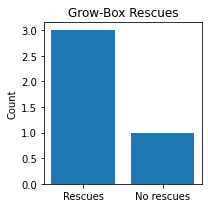

In [28]:
# %% 5  VISUALISE
# %% 5A  VISUALISE — rescues (count)
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.bar(['Rescues','No rescues'], [metrics['rescues'],metrics['no_rescues']])
plt.ylabel('Count')
plt.title('Grow-Box Rescues')
plt.tight_layout()
plt.show()


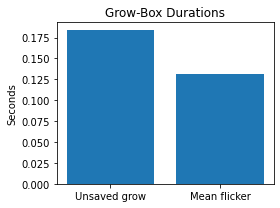

In [29]:
# %% 5B  VISUALISE — durations (seconds, consistent units)
unsaved_sec  = metrics['unsaved_grow_ms'] / 1000      # ms → s
flicker_sec  = metrics['mean_flicker_ms'] / 1000      # ms → s

plt.figure(figsize=(4,3))
plt.bar(['Unsaved grow', 'Mean flicker'],
        [unsaved_sec, flicker_sec])
plt.ylabel('Seconds')
plt.title('Grow-Box Durations')
plt.tight_layout()
plt.show()

In [30]:
# %% 6  SAVE OUTPUTS
ep.to_csv(EP_OUT, index=False)
with open(MET_OUT, 'w') as f: json.dump(metrics, f, indent=2)

print(f"episodes ➜ {EP_OUT}")
print(f"metrics  ➜ {MET_OUT}")


episodes ➜ episodes.csv
metrics  ➜ metrics.json
